# Notebook 02: External Factors and Feature Engineering

**Project:** Retail Demand Forecasting & Inventory Optimization for Walmart

## 1. Business Context

In the previous notebook, we identified strong internal patterns like seasonality and the impact of store characteristics. Now, we'll analyze external factors that Walmart's demand planners must consider, such as weather, fuel prices, and economic conditions.

The second, more technical, goal of this notebook is **Feature Engineering**. We will create new, model-ready features from our existing data. These features, such as time lags and rolling averages, are crucial for helping our machine learning models understand concepts like trend, momentum, and seasonality.

## 2. Objectives

*   Analyze the correlation between weekly sales and external factors (`Temperature`, `Fuel_Price`, `CPI`, `Unemployment`).
*   Investigate the impact of promotional markdowns on sales.
*   Engineer time-based features to better capture seasonality.
*   Create lag and rolling-window features to provide the model with a sense of historical context.
*   Save the final, feature-rich dataset for the modeling phase.

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set visualization style
sns.set_style('whitegrid')
plt.style.use('fivethirtyeight')
%matplotlib inline

# Load the processed data from the previous notebook
try:
    df = pd.read_csv('../data/processed/walmart_sales_data_processed.csv')
except FileNotFoundError:
    print("Processed data file not found. Please run Notebook 01 first to generate it.")

# Convert 'Date' back to datetime object as CSV does not preserve this
df['Date'] = pd.to_datetime(df['Date'])

df.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Year,Month,WeekOfYear
0,1,1,2010-02-05,24924.50,False,A,151315,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,2010,2,5
1,1,1,2010-02-12,46039.49,True,A,151315,38.51,2.548,0.0,0.0,0.0,0.0,0.0,211.242170,8.106,2010,2,6
2,1,1,2010-02-19,41595.55,False,A,151315,39.93,2.514,0.0,0.0,0.0,0.0,0.0,211.289143,8.106,2010,2,7
3,1,1,2010-02-26,19403.54,False,A,151315,46.63,2.561,0.0,0.0,0.0,0.0,0.0,211.319643,8.106,2010,2,8
4,1,1,2010-03-05,21827.90,False,A,151315,46.50,2.625,0.0,0.0,0.0,0.0,0.0,211.350143,8.106,2010,3,9


## 3. Analysis of External Factors

Let's investigate the relationship between `Weekly_Sales` and the provided external features. We will use scatter plots and correlation analysis to quantify these relationships. Since we have many data points, we'll use a sample to make the scatter plots readable.

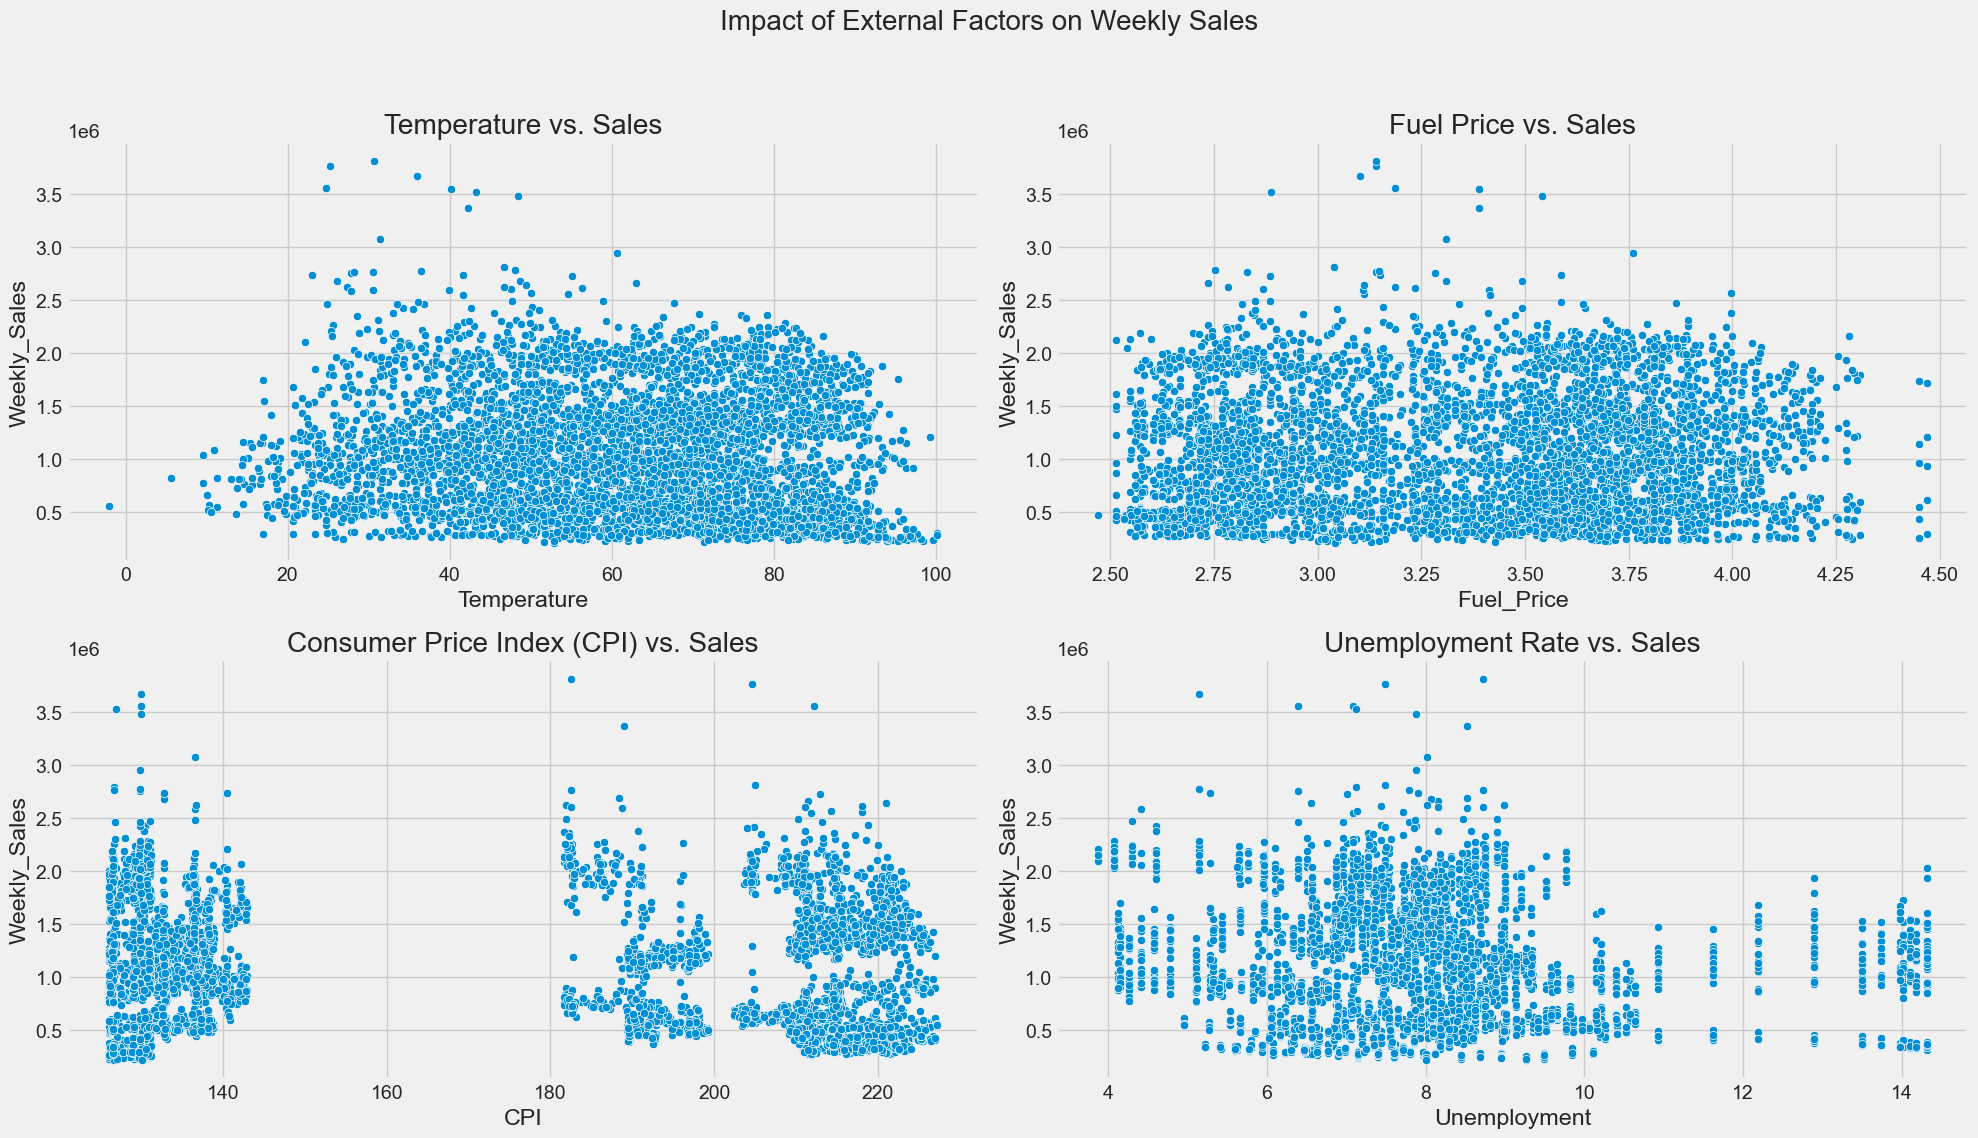

--- Correlation Matrix ---
Weekly_Sales    1.000000
Temperature    -0.063810
Fuel_Price      0.009464
CPI            -0.072634
Unemployment   -0.106176
Name: Weekly_Sales, dtype: float64


In [2]:
# We'll use the store-level aggregated data for cleaner visualizations
store_level_sales = df.groupby(['Store', 'Date']).agg({
    'Weekly_Sales': 'sum',
    'Temperature': 'first',
    'Fuel_Price': 'first',
    'CPI': 'first',
    'Unemployment': 'first'
}).reset_index()

# Create a sample to avoid overplotting
sample_df = store_level_sales.sample(n=5000, random_state=42)

# Plotting the relationships
fig, axes = plt.subplots(2, 2, figsize=(20, 12))
fig.suptitle('Impact of External Factors on Weekly Sales', fontsize=20)

# Temperature vs. Weekly_Sales
sns.scatterplot(ax=axes[0, 0], data=sample_df, x='Temperature', y='Weekly_Sales')
axes[0, 0].set_title('Temperature vs. Sales')

# Fuel_Price vs. Weekly_Sales
sns.scatterplot(ax=axes[0, 1], data=sample_df, x='Fuel_Price', y='Weekly_Sales')
axes[0, 1].set_title('Fuel Price vs. Sales')

# CPI vs. Weekly_Sales
sns.scatterplot(ax=axes[1, 0], data=sample_df, x='CPI', y='Weekly_Sales')
axes[1, 0].set_title('Consumer Price Index (CPI) vs. Sales')

# Unemployment vs. Weekly_Sales
sns.scatterplot(ax=axes[1, 1], data=sample_df, x='Unemployment', y='Weekly_Sales')
axes[1, 1].set_title('Unemployment Rate vs. Sales')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# Calculate correlation matrix
correlation_matrix = store_level_sales[['Weekly_Sales', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment']].corr()
print("--- Correlation Matrix ---")
print(correlation_matrix['Weekly_Sales'])

**Insight:**
*   **Temperature:** The scatter plot shows a slight non-linear pattern, where sales appear to dip at the extreme ends of the temperature range. The linear correlation is very weak (-0.06).
*   **Fuel Price, CPI & Unemployment:** The linear correlation for these economic factors is also very weak and does not show a clear, direct relationship with weekly sales in the scatter plots.

**Conclusion on External Factors:**
While the direct **linear correlation** of these external factors with weekly sales is low, it would be premature to discard them. These factors may have complex, **non-linear relationships** or **interactive effects** (e.g., the impact of fuel prices might be stronger when unemployment is also high).

A powerful, non-linear model like LightGBM is specifically designed to uncover such relationships. Therefore, we will **retain these variables as features**. The model's feature importance analysis in the next stage will be the ultimate arbiter of their predictive value.

## 4. Feature Engineering for Time Series Models

To prepare for modeling, we need to create features that explicitly provide our models with historical and seasonal context. We will engineer three main types of features:
1.  **Time-Based Features:** More granular details from the date.
2.  **Lag Features:** Sales from previous time periods (e.g., last week's sales, sales from this week last year).
3.  **Rolling Window Features:** Aggregations over a recent time window (e.g., the average sales over the last 4 weeks).

We will perform these operations on the original `df` which is at the `Store-Dept` level, as our final goal is to predict sales for each department.

In [3]:
# Sort the data properly before creating lag/rolling features
df.sort_values(['Store', 'Dept', 'Date'], inplace=True)

# --- Lag Features ---
# We want to create a lag for 52 weeks to capture the strong annual seasonality.
# A short-term lag (e.g., 1 week) could also be useful.
df['Weekly_Sales_Lag_52'] = df.groupby(['Store', 'Dept'])['Weekly_Sales'].shift(52)
df['Weekly_Sales_Lag_1'] = df.groupby(['Store', 'Dept'])['Weekly_Sales'].shift(1)


# --- Rolling Window Features ---
# A 4-week rolling mean can help capture the recent trend.
df['Weekly_Sales_4_Week_Mean'] = df.groupby(['Store', 'Dept'])['Weekly_Sales'].shift(1).rolling(window=4).mean()


# --- Handling NaNs created by lags/rolling windows ---
# These methods create NaNs for the first few data points for each group.
# For a production model, we might need a more complex strategy,
# but for this project, we can drop them as we have plenty of data.
initial_rows = df.shape[0]
df.dropna(inplace=True)
print(f"Dropped {initial_rows - df.shape[0]} rows with NaN values created by feature engineering.")


print("\n--- DataFrame with New Features ---")
df[['Date', 'Store', 'Dept', 'Weekly_Sales', 'Weekly_Sales_Lag_52', 'Weekly_Sales_Lag_1', 'Weekly_Sales_4_Week_Mean']].head(10)

Dropped 160487 rows with NaN values created by feature engineering.

--- DataFrame with New Features ---


,Date,Store,Dept,Weekly_Sales,Weekly_Sales_Lag_52,Weekly_Sales_Lag_1,Weekly_Sales_4_Week_Mean
52,2011-02-04,1,1,21665.76,24924.50,18461.18,17286.6475
53,2011-02-11,1,1,37887.17,46039.49,21665.76,18707.0275
54,2011-02-18,1,1,46845.87,41595.55,37887.17,23838.8950
55,2011-02-25,1,1,19363.83,19403.54,46845.87,31214.9950
56,2011-03-04,1,1,20327.61,21827.90,19363.83,31440.6575
57,2011-03-11,1,1,21280.40,21043.39,20327.61,31106.1200
58,2011-03-18,1,1,20334.23,22136.64,21280.40,26954.4275
59,2011-03-25,1,1,20881.10,26229.21,20334.23,20326.5175
60,2011-04-01,1,1,20398.09,57258.43,20881.10,20705.8350
61,2011-04-08,1,1,23873.79,42960.91,20398.09,20723.4550


**Feature Rationale:**
*   `Weekly_Sales_Lag_52`: This is our most powerful feature for seasonality. The model can now directly compare this week's sales to the sales of the same week last year, which is a very strong predictor.
*   `Weekly_Sales_Lag_1`: This feature captures momentum. If sales were high last week, they are likely to be high this week as well.
*   `Weekly_Sales_4_Week_Mean`: This feature smooths out recent noise and gives the model a sense of the current sales trend. It helps the model understand if sales are generally increasing or decreasing in the short term.

## 5. Save the Feature-Engineered Dataset

Our data is now enriched with valuable features. We will save this final dataset to be used in the next notebook for model building and comparison. We'll use the Parquet format, which is efficient for storing dataframes.

In [ ]:
# Save the feature-engineered data for the next notebook
try:
    output_path = '../data/'
    df.to_parquet(output_path + 'walmart_sales_data_feature_engineered.parquet', index=False)
    print(f"Feature-engineered data saved to {output_path}walmart_sales_data_feature_engineered.parquet")
except ImportError:
    print("Please install pyarrow: 'pip install pyarrow' to save as parquet.")
    # Fallback to CSV if pyarrow is not installed
    df.to_csv(output_path + 'walmart_sales_data_feature_engineered.csv', index=False)
    print(f"Feature-engineered data saved as CSV instead.")

Feature-engineered data saved to ../data/walmart_sales_data_feature_engineered.parquet


## 6. Key Findings and Next Steps

1.  **Limited Impact of External Factors:** The direct linear relationship between sales and factors like `Fuel_Price`, `CPI`, and `Unemployment` is weak. These are likely secondary drivers compared to the powerful effect of seasonality.
2.  **Creation of High-Value Features:** We have successfully created lag and rolling window features. These will allow our models to "see" into the past and understand seasonal patterns and recent trends, which is critical for accurate forecasting.

**Next Steps:**

In the next notebook, `03_demand_forecasting_models_comparison.ipynb`, we will finally begin building our forecasting models. We will use this feature-rich dataset to:
*   Establish a performance baseline.
*   Train and evaluate a traditional statistical model.
*   Train and evaluate modern machine learning models (like LightGBM or XGBoost).
*   Compare the models and select the best performer for our inventory optimization task.